In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [6]:
# @title Read file
df=pd.read_csv('FPT.csv')
df["Date/Time"]=pd.to_datetime(df["Date/Time"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         97406 non-null  object        
 1   Date/Time      97406 non-null  datetime64[ns]
 2   Open           97406 non-null  float64       
 3   High           97406 non-null  float64       
 4   Low            97406 non-null  float64       
 5   Close          97406 non-null  float64       
 6   Volume         97406 non-null  int64         
 7   Open Interest  97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 5.9+ MB
None


In [7]:
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,0
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,0
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,0
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,0
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,0


In [107]:
newdata = df.drop(columns=["Ticker"])
data=newdata.drop(columns=["Date/Time"])
data

,Open,High,Low,Close,Volume,Open Interest
0,30.89,30.89,30.89,30.89,35410,0
1,30.81,30.81,30.81,30.81,190,0
2,30.74,30.81,30.74,30.74,1120,0
3,30.74,30.74,30.74,30.74,2120,0
4,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...
97401,58.20,58.20,58.20,58.20,27470,0
97402,58.20,58.20,58.20,58.20,14820,0
97403,58.20,58.20,58.20,58.20,500,0
97404,58.10,58.10,58.10,58.10,2500,0


In [111]:
#@title Filter rows based on time criteria from 9h15 to 14h46
start_time = pd.to_datetime('09:15:00').time()
end_time = pd.to_datetime('14:46:00').time()

# Ensure that the time range is within a single day.
filtered_df = df[(df['Date/Time'].dt.time >= start_time) & (df['Date/Time'].dt.time <= end_time)]

#Check if the filtered data contains the full time range.
#Count unique dates for the filtered data
unique_dates = filtered_df['Date/Time'].dt.date.unique()
#print("unique dates", unique_dates)

# Iterate through unique dates
for date in unique_dates:
    daily_data = filtered_df[filtered_df['Date/Time'].dt.date == date]
    # Check if the daily data contains the full time range
    if not (daily_data['Date/Time'].dt.time.min() <= start_time and daily_data['Date/Time'].dt.time.max() >= end_time):
      # Remove the rows corresponding to the incomplete days
      filtered_df = filtered_df[filtered_df['Date/Time'].dt.date != date]

print(filtered_df.info())


data=filtered_df[['Date/Time', 'Close']]
data
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 96200 entries, 7 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         96200 non-null  object        
 1   Date/Time      96200 non-null  datetime64[ns]
 2   Open           96200 non-null  float64       
 3   High           96200 non-null  float64       
 4   Low            96200 non-null  float64       
 5   Close          96200 non-null  float64       
 6   Volume         96200 non-null  int64         
 7   Open Interest  96200 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 6.6+ MB
None


,Date/Time,Close
7,2018-12-26 09:15:00,31.11
8,2018-12-26 09:16:00,31.19
9,2018-12-26 09:17:00,31.19
10,2018-12-26 09:18:00,31.15
11,2018-12-26 09:19:00,31.11


In [113]:
# Calculate the percentage of null values in each column
null_percentage = data.isnull().sum() / len(data) * 100

# Identify columns with a high percentage of null values (e.g., >5%)
columns_to_impute = null_percentage[null_percentage > 5].index

# Identify columns with a low percentage of null values (e.g., <=5%)
columns_to_drop = null_percentage[null_percentage <= 5].index

# Impute missing values in columns with high null percentages using median
for col in columns_to_impute:
    median_value = data[col].median()
    data[col].fillna(median_value, inplace=True)

# Drop rows with missing values in columns with low null percentages
data.dropna(subset=columns_to_drop, inplace=True)

data

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8224\185271170.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=columns_to_drop, inplace=True)


,Date/Time,Close
7,2018-12-26 09:15:00,31.11
8,2018-12-26 09:16:00,31.19
9,2018-12-26 09:17:00,31.19
10,2018-12-26 09:18:00,31.15
11,2018-12-26 09:19:00,31.11
...,...,...
97401,2020-12-22 14:24:00,58.20
97402,2020-12-22 14:25:00,58.20
97403,2020-12-22 14:26:00,58.20
97404,2020-12-22 14:29:00,58.10


In [114]:
data.columns

Index(['Date/Time', 'Close'], dtype='object')

In [116]:
def describle(df: pd.DataFrame )-> pd.DataFrame:
	df_min= df.min()
	df_max= df.max()
	df_mean= df.mean()
	df_median= df.median()
	df_count= df.count()
	df_q1= df.quantile(0.25)
	df_q2= df.quantile(0.5)
	df_q3= df.quantile(0.75)
	df_iqr= df.quantile(0.75)- df.quantile(0.25)
	df_std= df.std()
	df_mode= df.mode().values[0]
	data = pd.DataFrame({
		"min":df_min,
		"max":df_max,
		"mean":df_mean,
		"count":df_count,
		"Q1":df_q1,
		"Q2":df_q2,
		"Q3":df_q3,
		"IQR":df_q3-df_q2,
		"std":df_std,
		"mode": df_mode
	})
	return data

In [117]:
datacheck= data.drop(columns=["Date/Time"])
describle(datacheck).transpose()

,Close
min,30.250000
max,58.400000
mean,45.044078
count,96200.000000
Q1,39.660000
Q2,46.950000
Q3,49.170000
IQR,2.220000
std,6.365976
mode,48.660000


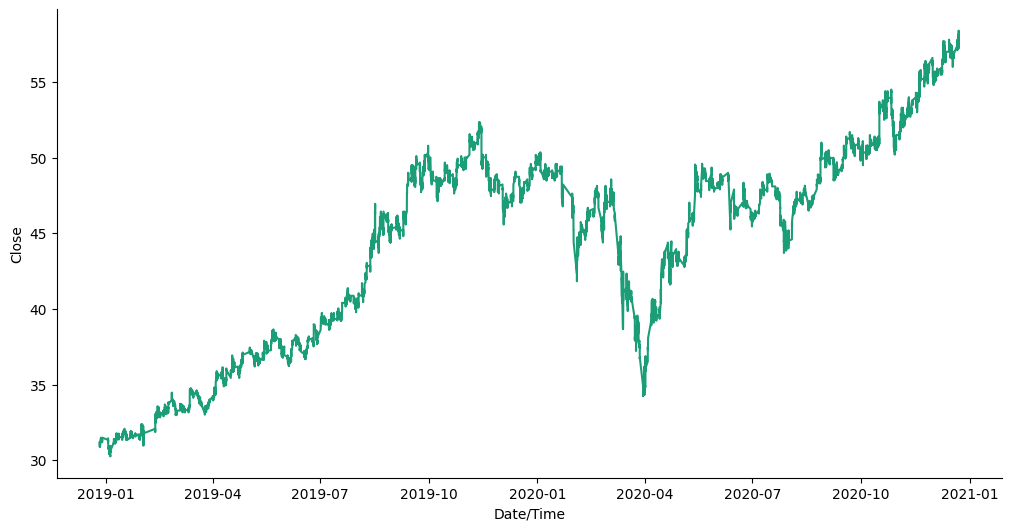

In [118]:
# @title Graph of Date/Time vs Close

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date/Time']
  ys = series['Close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date/Time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date/Time')
_ = plt.ylabel('Close')

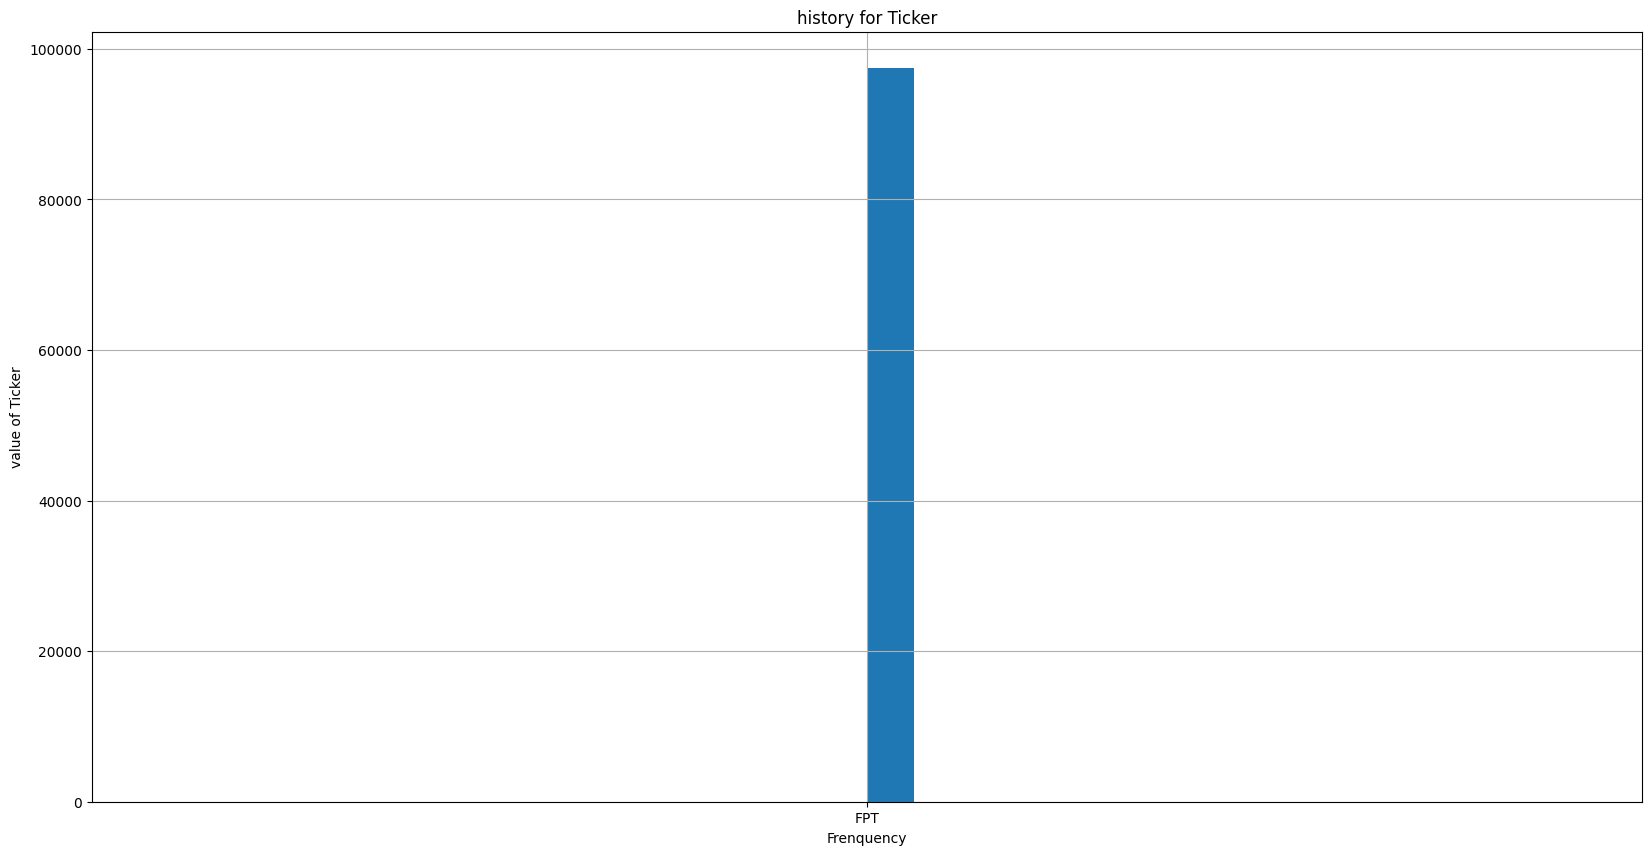

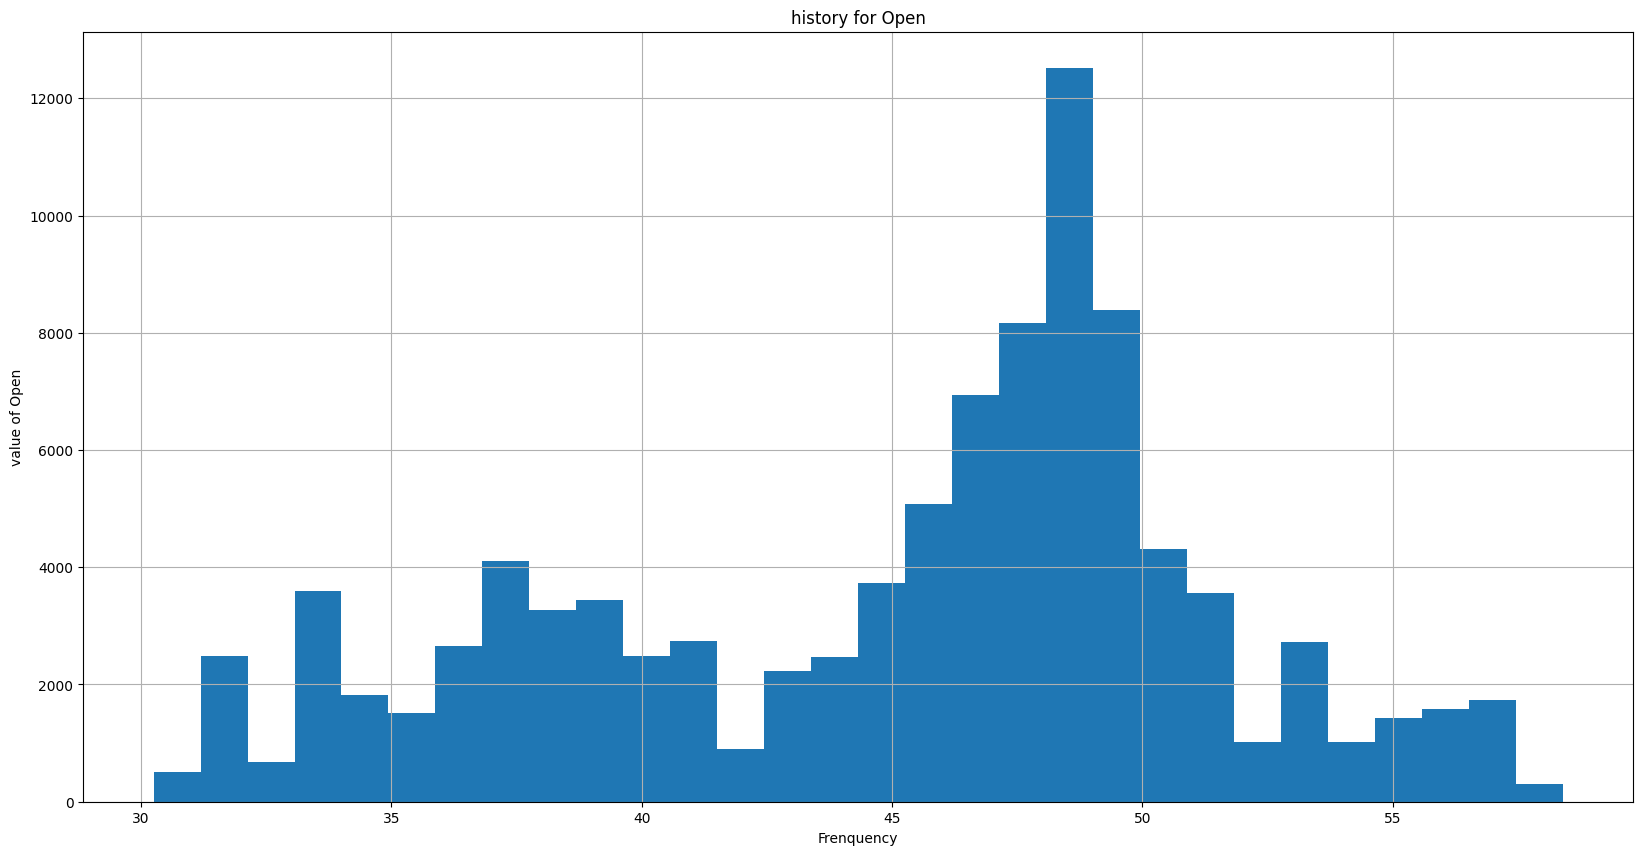

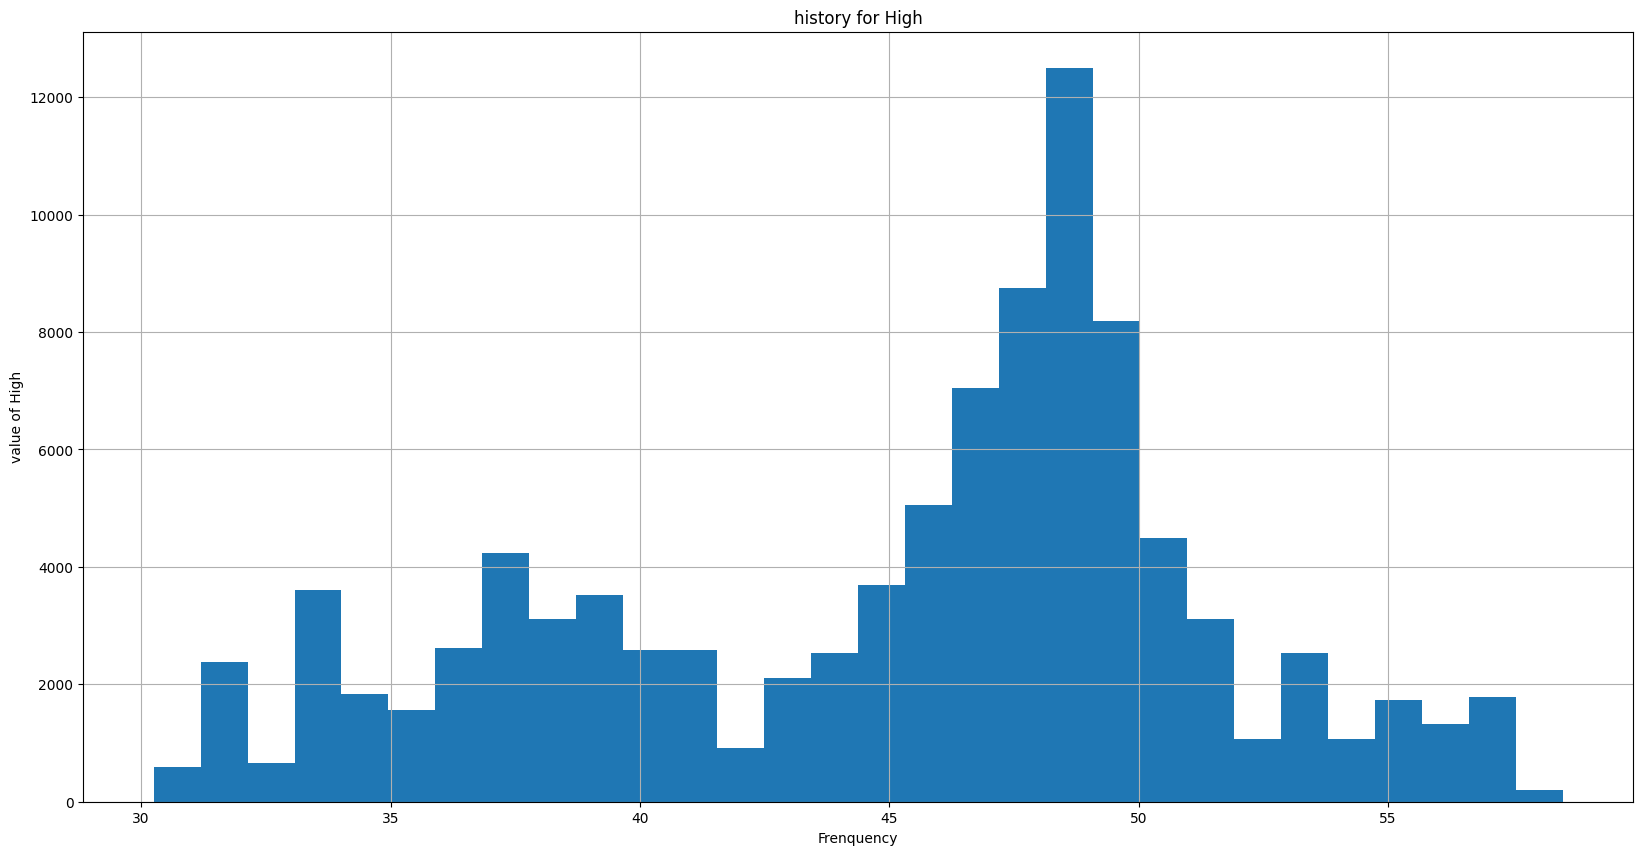

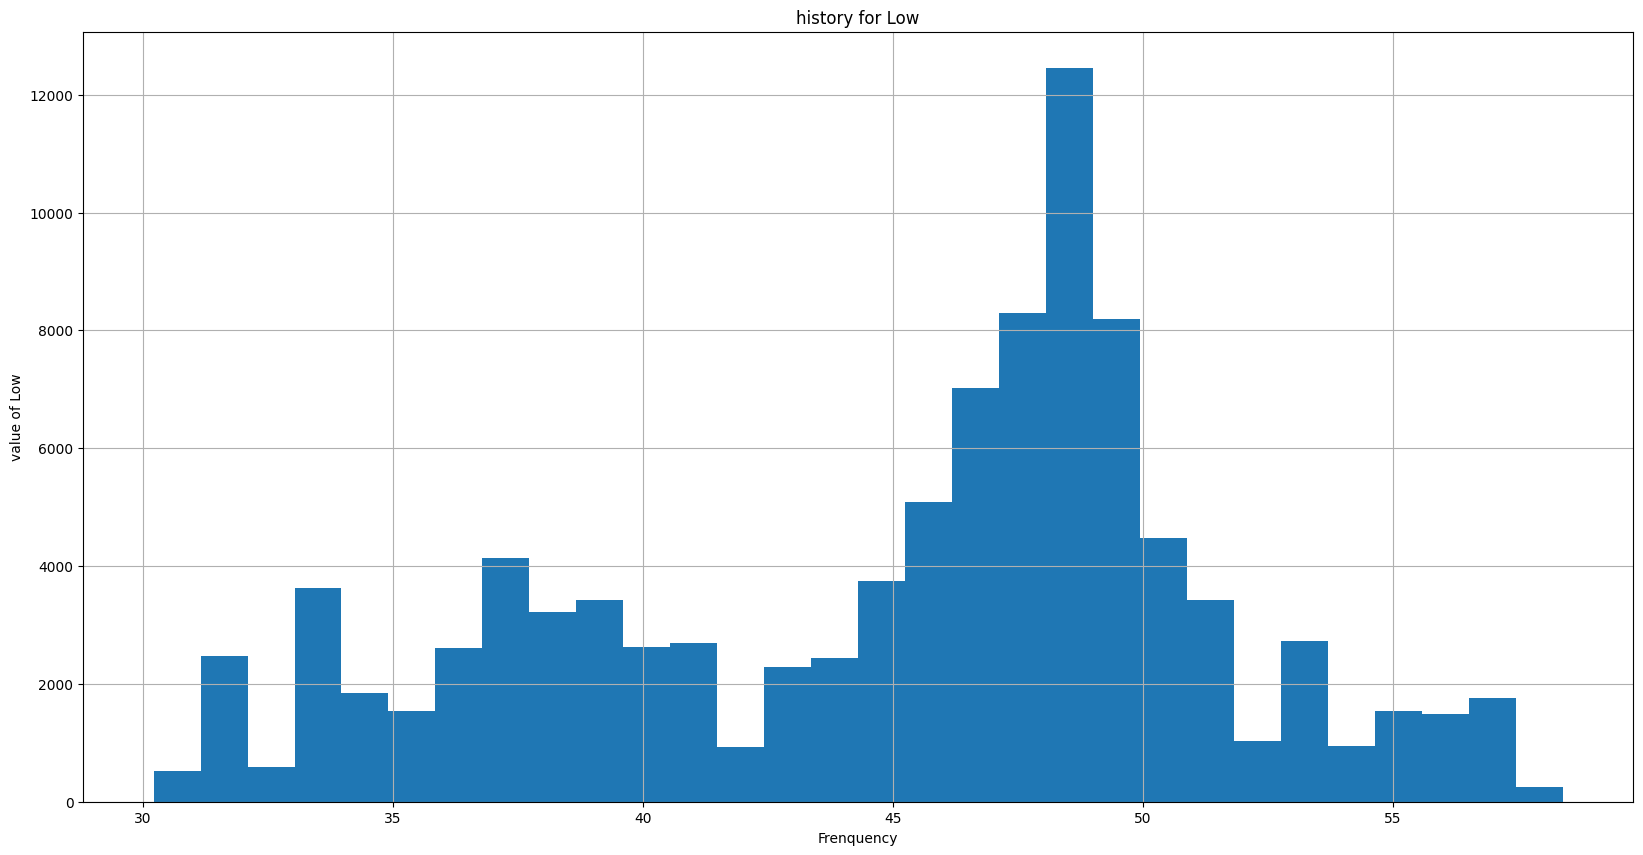

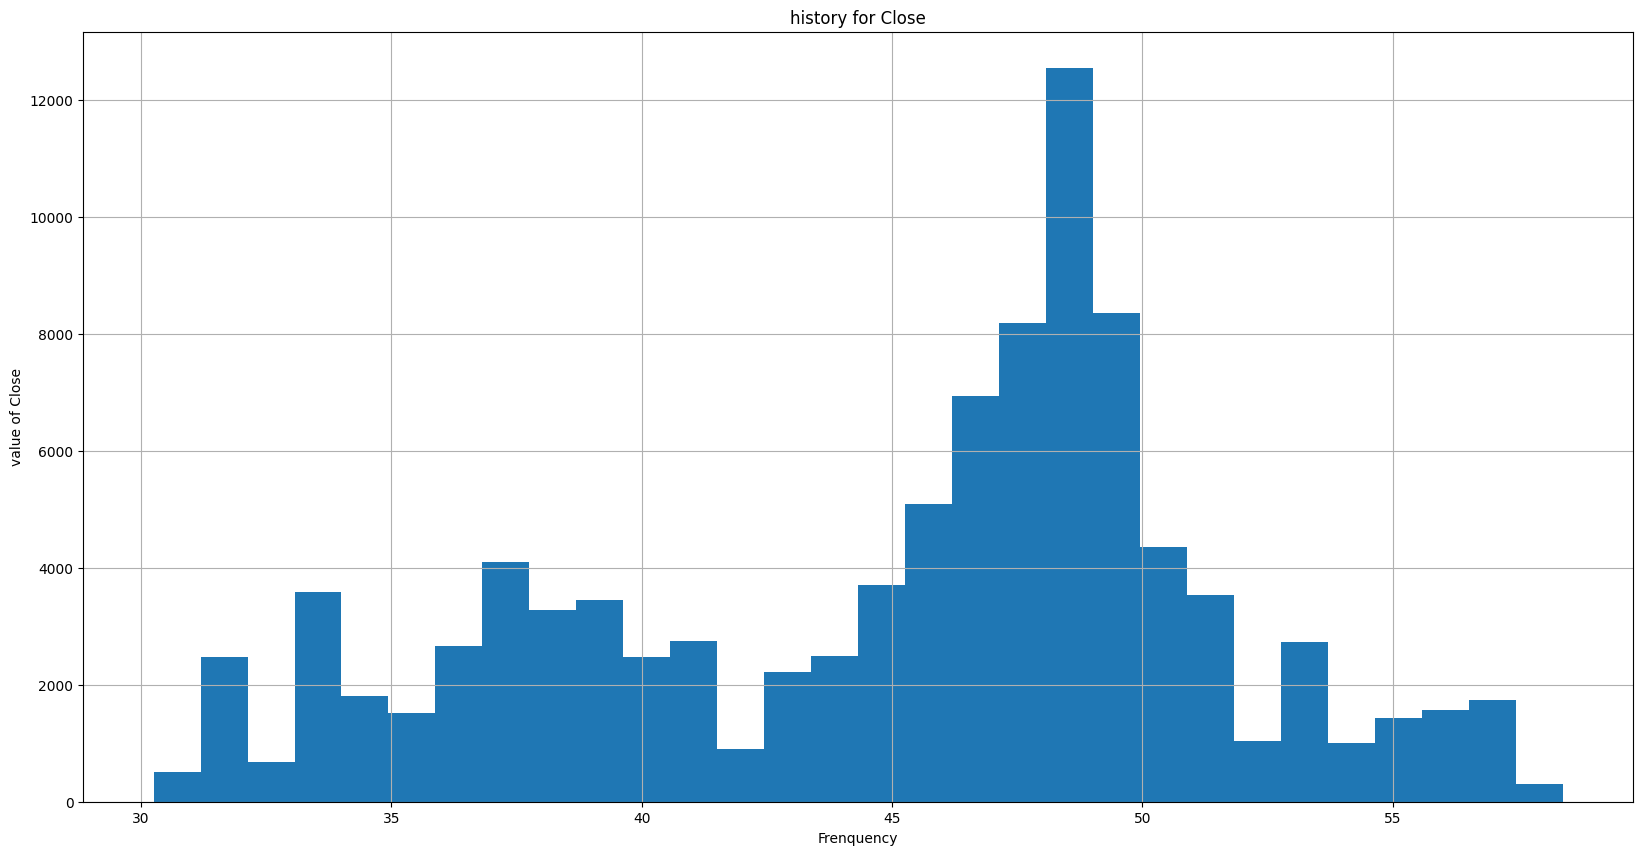

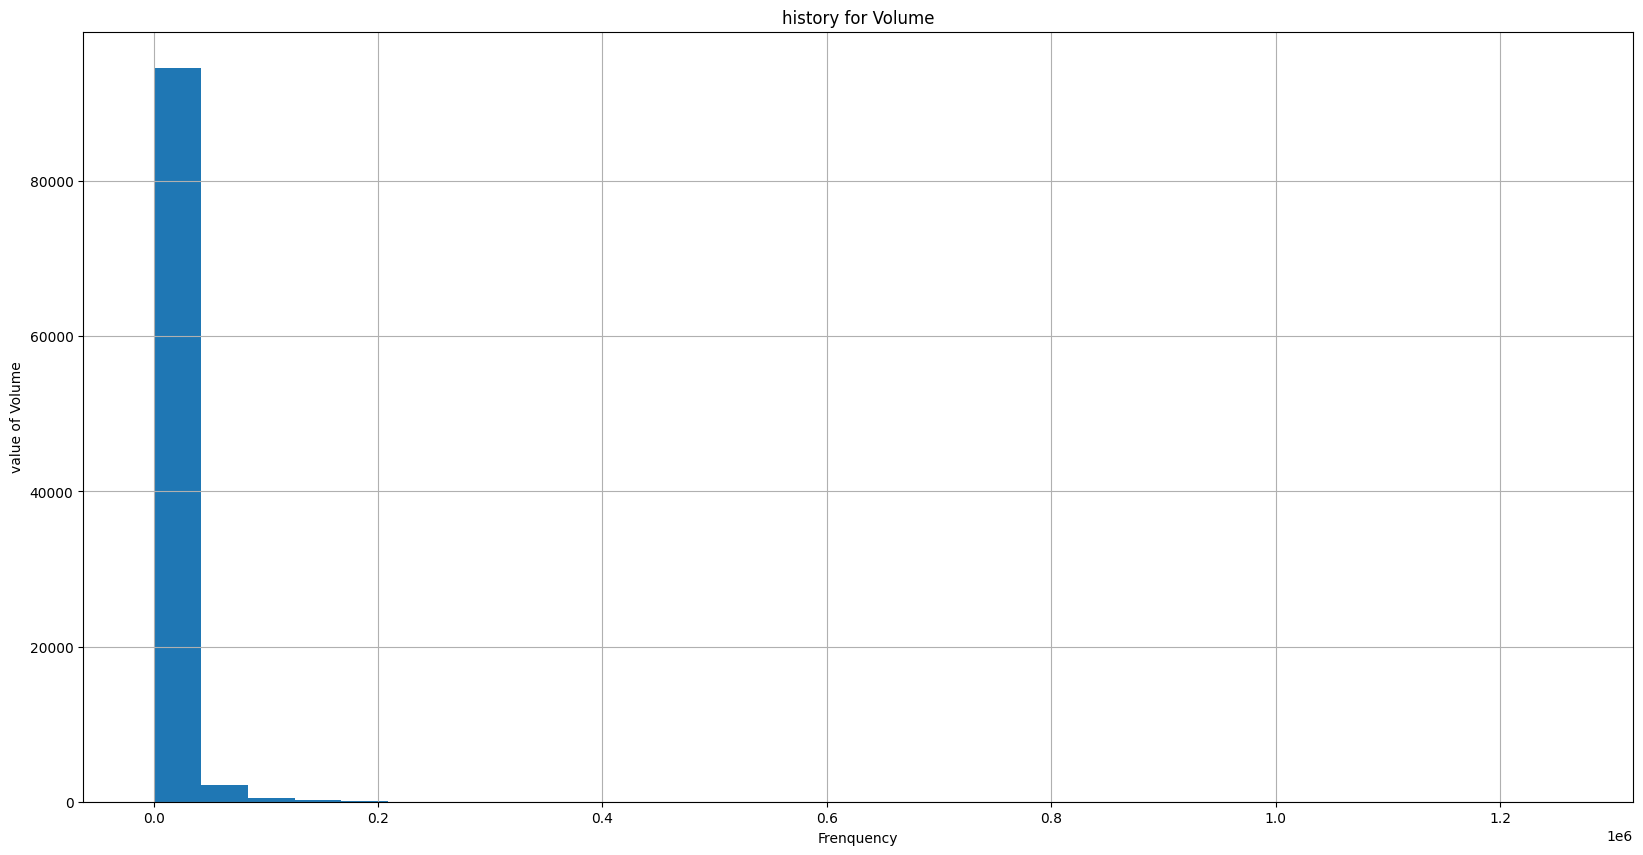

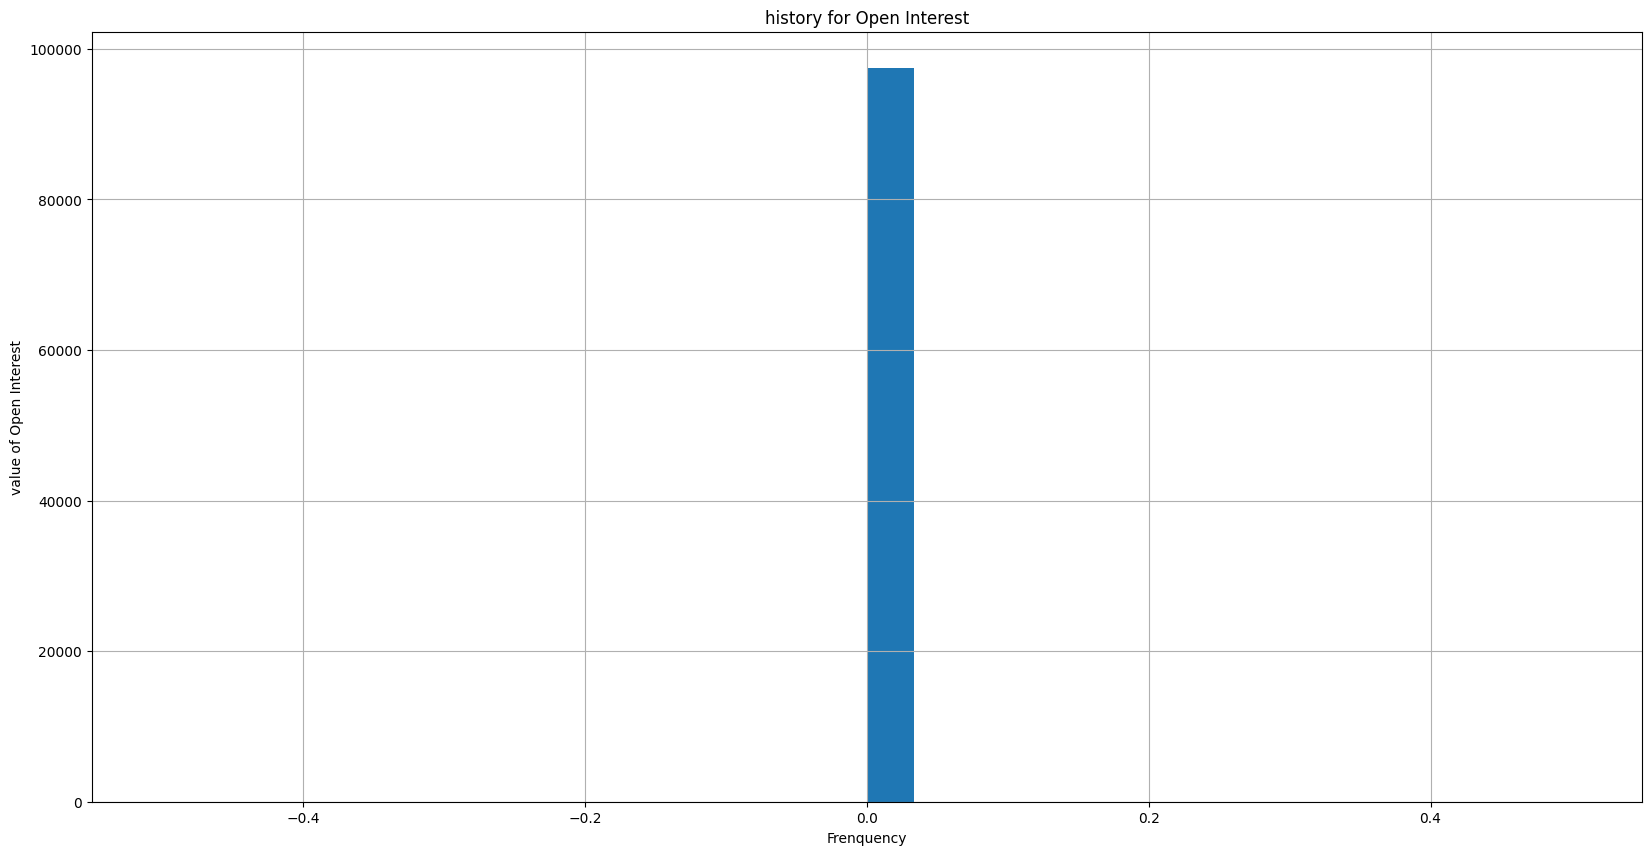

In [25]:
# bieu do cot
def hist(df:pd.DataFrame, str:str):
  plt.figure(figsize=(20, 10))
  plt.title(f"history for {str}")
  plt.hist(df[str], bins=30)
  plt.xlabel(f"Frenquency")
  plt.ylabel(f"value of {str}")
  plt.grid()
  plt.show()
for i in df.columns:
	if i != "Date/Time":
		hist(df, i)

In [32]:
def box_plot(data: pd.DataFrame, str:str):
	plt.title(f"box plot for {str}")
	plt.boxplot(data[str])
	plt.ylabel(f'Frenquency')
	plt.show()

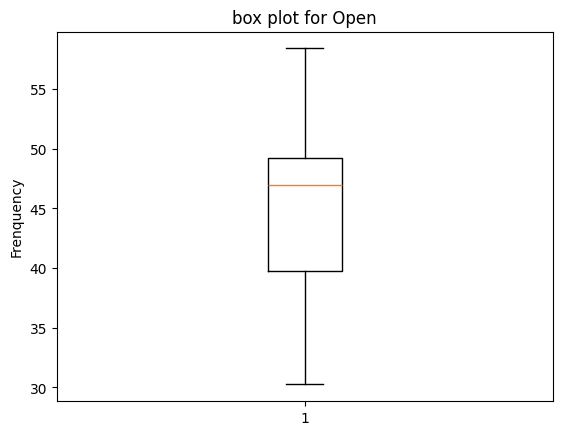

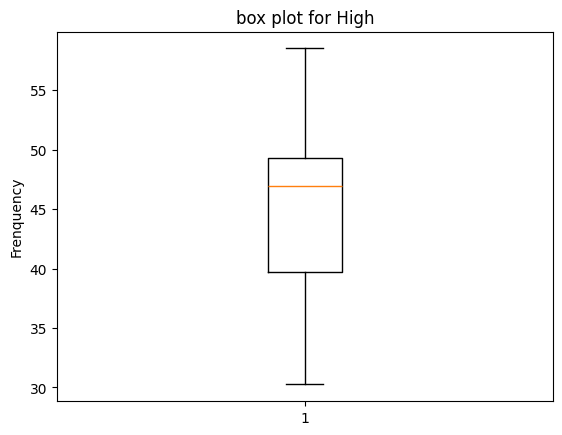

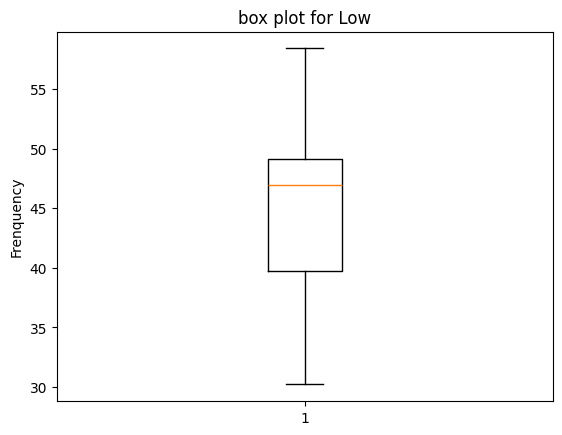

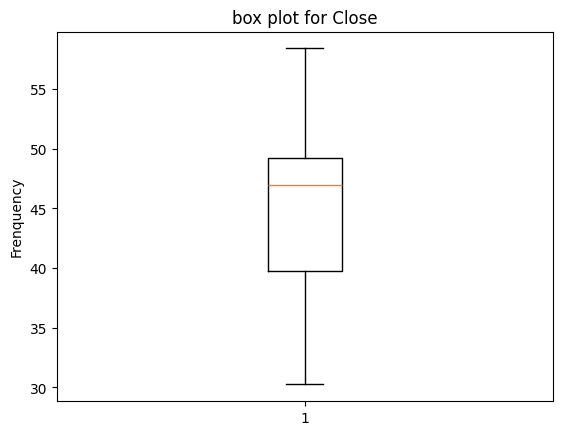

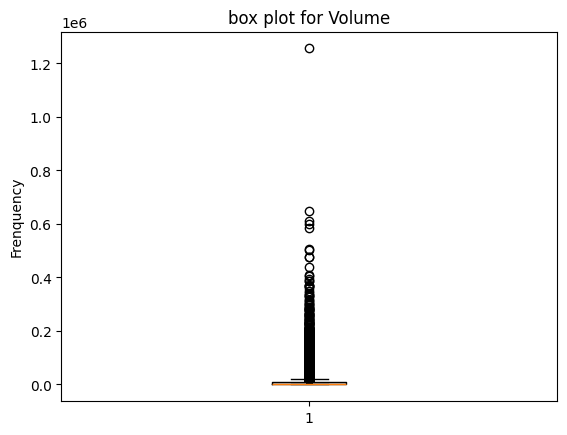

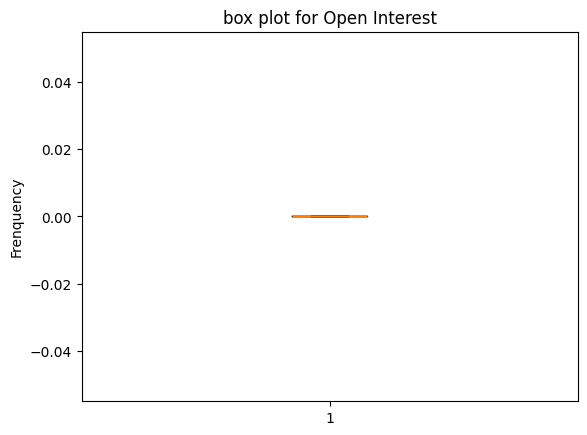

In [119]:
# Filter numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
	box_plot(df, col)

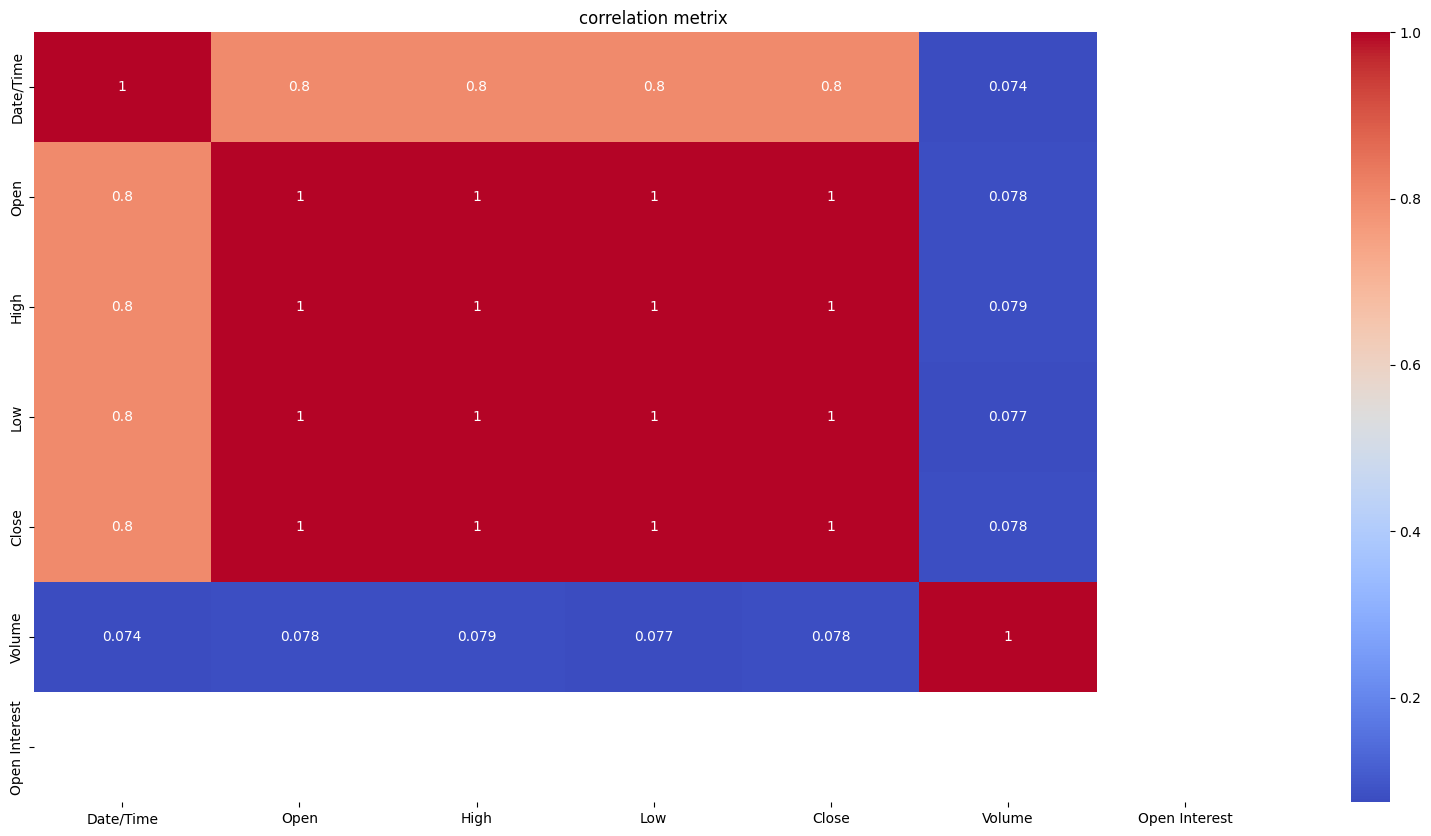

In [120]:

plt.figure(figsize=(20,10))
corr_metrix= newdata[newdata.columns].corr()
sns.heatmap(corr_metrix, annot=True, cmap="coolwarm")
plt.title("correlation metrix")
plt.show()

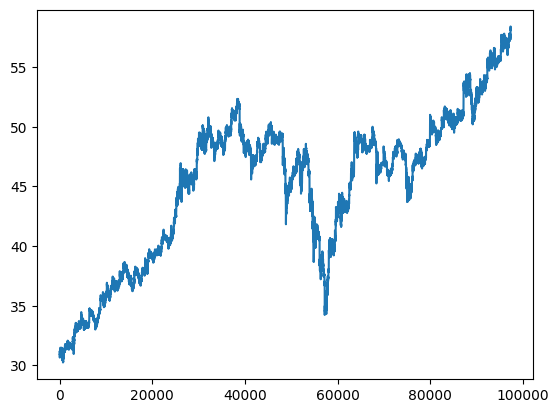

In [122]:
df_close= df["Close"]
plt.plot(df_close)

In [123]:
# Extract the numerical feature ('Close') for scaling
numerical_data = data[['Close']]

# Fit and transform the scaler on the numerical data only
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(numerical_data)


scaled_data


array([[0.03055062],
       [0.03339254],
       [0.03339254],
       ...,
       [0.9928952 ],
       [0.98934281],
       [0.98934281]])

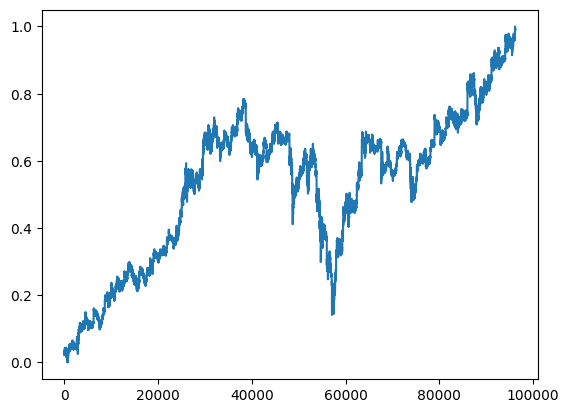

In [124]:
scaled_data.min(), scaled_data.max()
plt.plot(scaled_data)

In [45]:
split_ratio = 0.7
timesteps = 500
features = 1

total_samples = data.shape[0]
train_len = int(total_samples * split_ratio)
test_len = total_samples - train_len


X_train = []
y_train = []
for i in range(timesteps, train_len):
    X_train.append(scaled_data[i-timesteps:i, :])
    y_train.append(scaled_data[i, :])

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)


X_test = []
y_test = []
for i in range(train_len + timesteps, total_samples):
    X_test.append(scaled_data[i-timesteps:i, :])
    y_test.append(scaled_data[i, :])

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Train set shape: (66840, 500, 1) (66840, 1)
Test set shape: (28360, 500, 1) (28360, 1)


In [62]:
model = Sequential()

model.add(LSTM(64,input_shape=(X_train.shape[1],1),return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 500, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 500, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │           425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,899 (128.51 KB)

 Trainable params: 32,899 (128.51 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
from keras.optimizers import Adam
model.compile(optimizer= Adam(learning_rate= 0.001), loss= "mae" )
model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 261s 247ms/step - loss: 0.0254
Epoch 2/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 300s 287ms/step - loss: 0.0049
Epoch 3/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 250s 239ms/step - loss: 0.0044
Epoch 4/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 277s 265ms/step - loss: 0.0039
Epoch 5/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 284s 272ms/step - loss: 0.0036
Epoch 6/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 223s 214ms/step - loss: 0.0040
Epoch 7/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 276s 265ms/step - loss: 0.0031
Epoch 8/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 259s 248ms/step - loss: 0.0032
Epoch 9/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 226s 216ms/step - loss: 0.0028
Epoch 10/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 253s 242ms/step - loss: 0.0028
Epoch 11/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 275s 263ms/step - loss: 0.0028
Epoch 12/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 315s 302ms/step - loss: 0.0027
Epoch 13/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 266s 255ms/step - loss: 0.0025
Epoch 14/30
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 281s

In [64]:

from sklearn.metrics import accuracy_score
y_pred= model.predict(X_test)#du doan trong min max 0-1


887/887 ━━━━━━━━━━━━━━━━━━━━ 92s 102ms/step


In [65]:
y_test.shape

(28360, 1)

In [66]:
inv_y_predicts=scaler.inverse_transform( y_pred ) # chuyen min max sang dang thuc
inv_y_test=scaler.inverse_transform( y_test.reshape(-1, y_pred.shape[-1]))

In [67]:
print(inv_y_predicts.shape)
print(inv_y_test.shape)

(28360, 1)
(28360, 1)


In [69]:
from sklearn.metrics import median_absolute_error, mean_squared_error
mae = mean_squared_error(inv_y_predicts, inv_y_test )
print("Median absolute error:", mae)

Median absolute error: 0.0050436184613567355


In [86]:
data_pre = pd.DataFrame({
    "y_test": inv_y_test.reshape(-1),
    "y_pred": inv_y_predicts.reshape(-1),
    "Date/Time": df['Date/Time'].iloc[train_len + 1706: train_len + 1706+ len(inv_y_test)],
}
)


In [87]:
data_pre.head()

,y_test,y_pred,Date/Time
69046,47.5,47.796906,2020-06-16 14:23:00
69047,47.5,47.582581,2020-06-16 14:24:00
69048,47.5,47.539051,2020-06-16 14:26:00
69049,47.2,47.525829,2020-06-16 14:27:00
69050,47.2,47.286098,2020-06-16 14:28:00


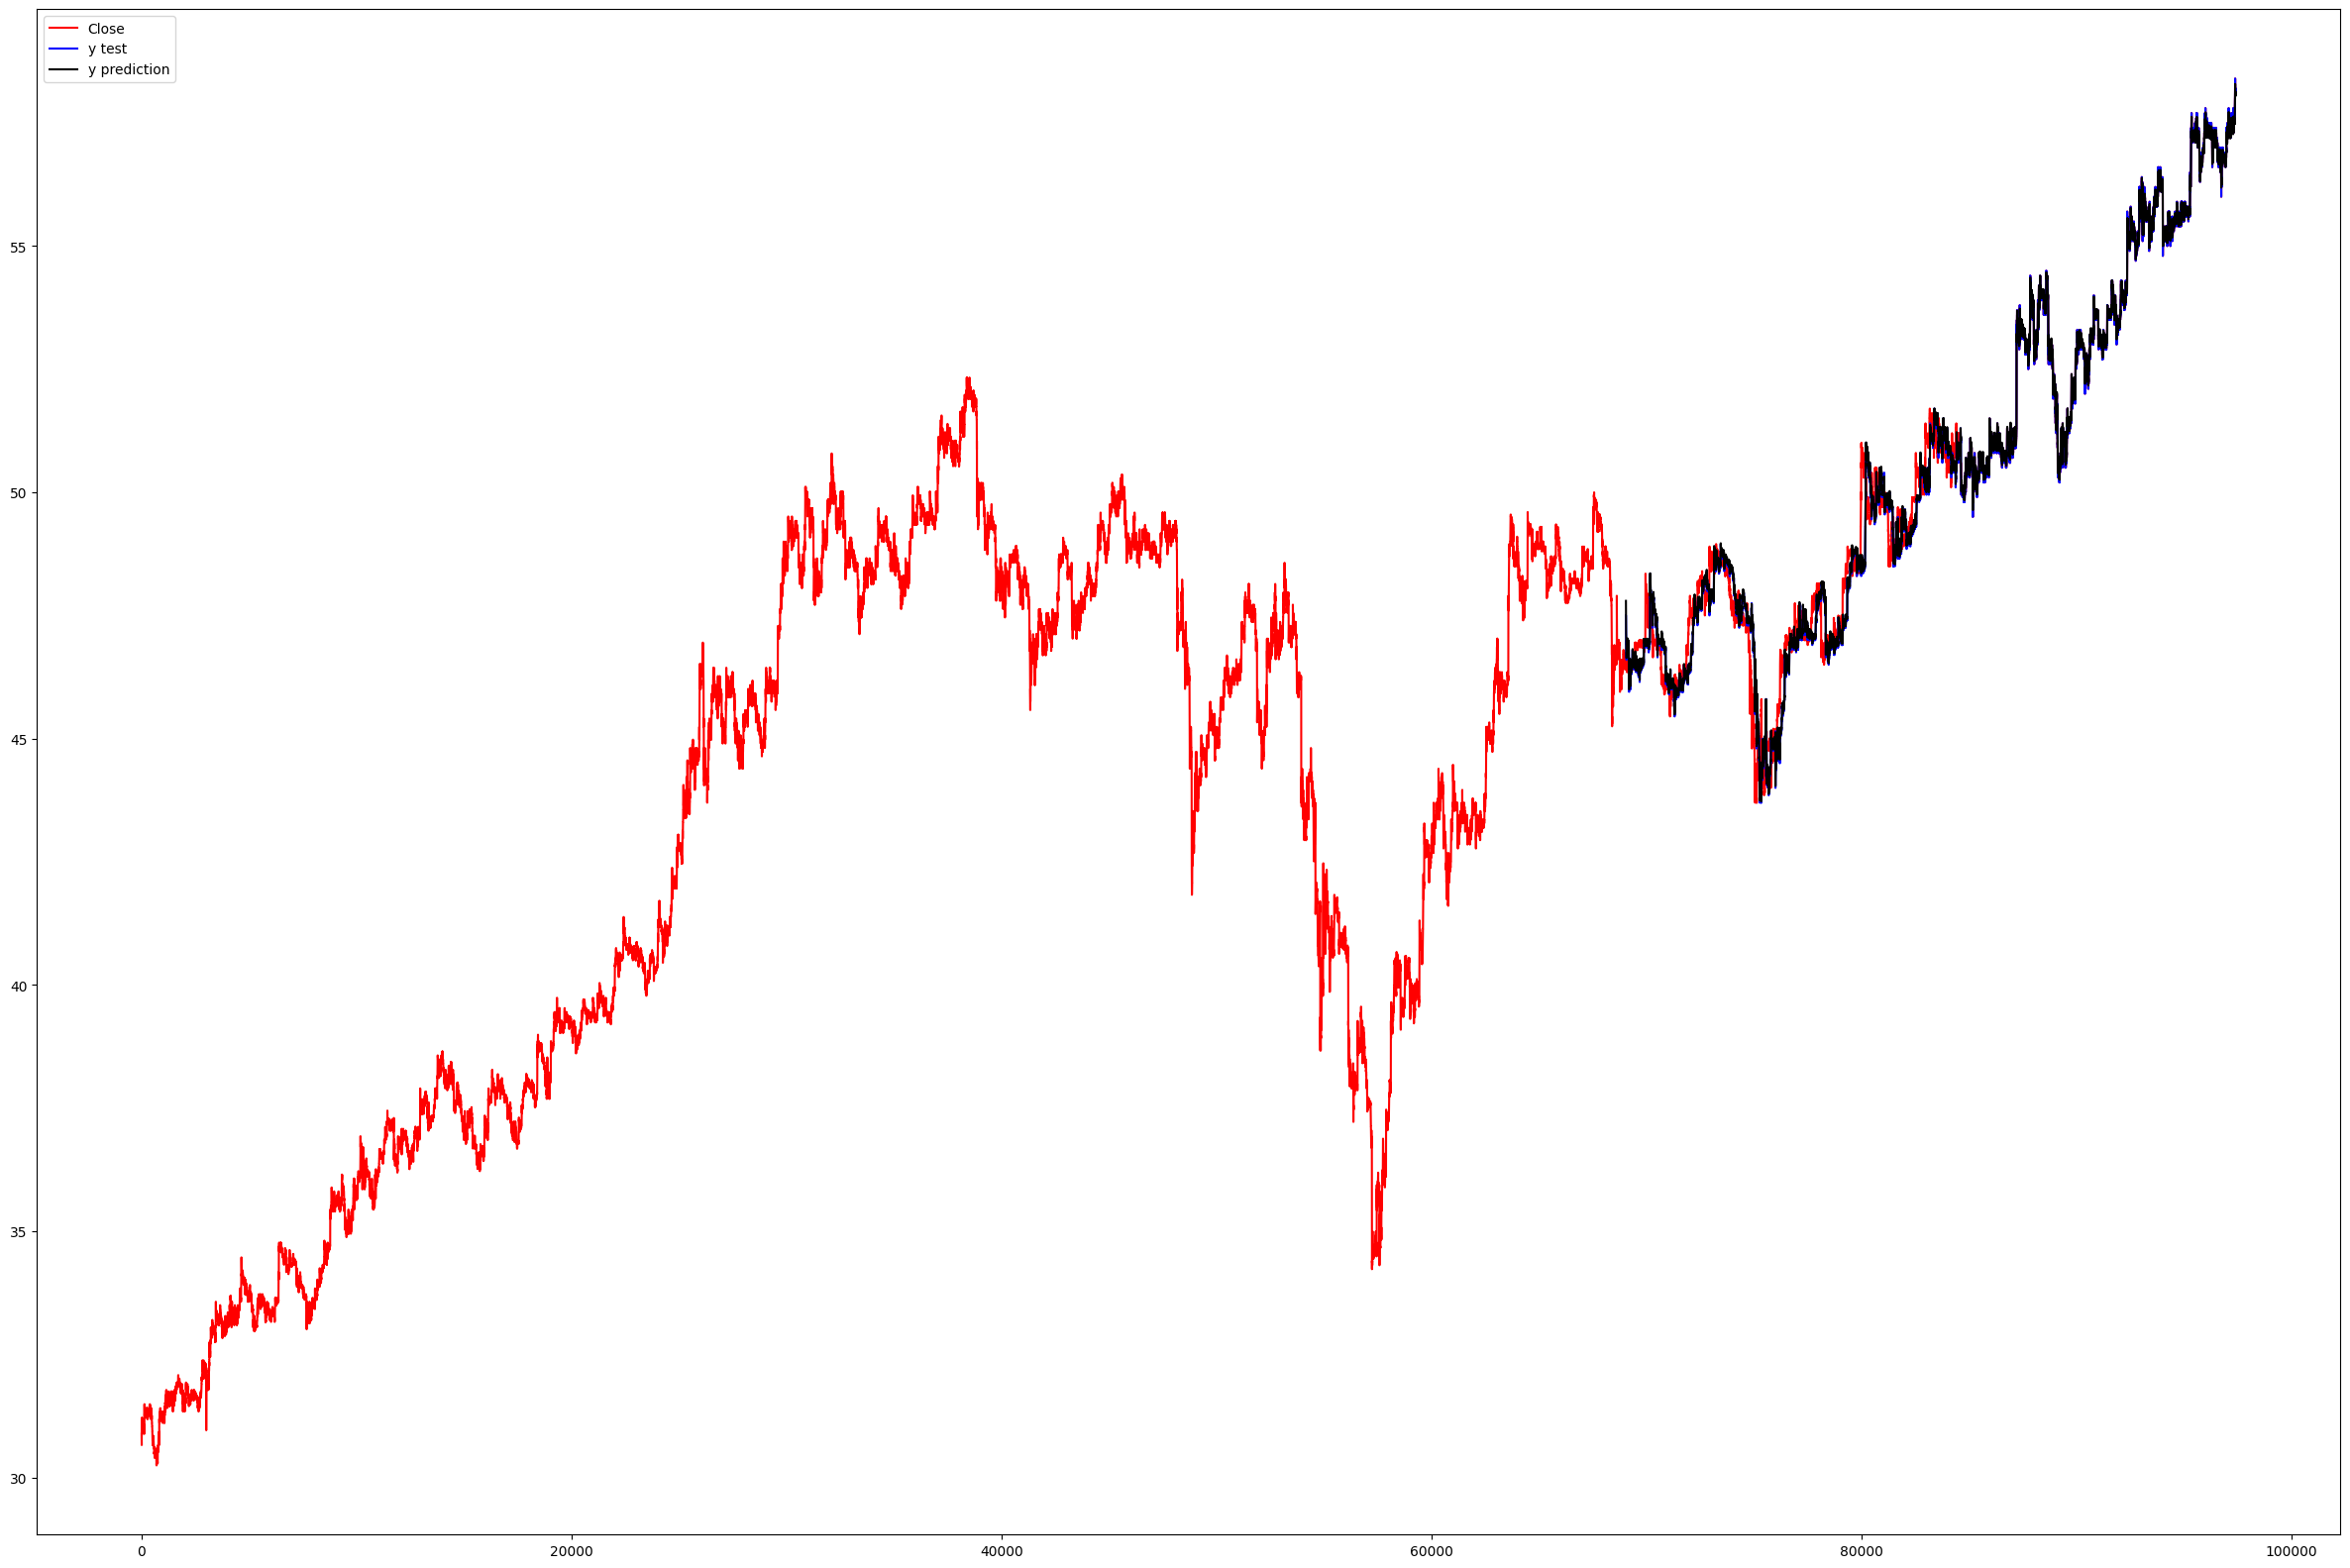

In [88]:

plt.figure(figsize=(30,20))
plt.plot(df["Close"], color="red", label="Close")
plt.plot(data_pre["y_test"], color="blue", label="y test")
plt.plot(data_pre["y_pred"],color="black", label="y prediction")
plt.legend()
plt.show()


In [89]:
model.save("modelStockPrediction.keras")

In [90]:
from tensorflow.keras.models import load_model
model= load_model("modelStockPrediction.keras")
model.predict(X_test)

887/887 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/step


array([[0.62333596],
       [0.6157222 ],
       [0.6141759 ],
       ...,
       [0.9901904 ],
       [0.99035037],
       [0.98813987]], dtype=float32)